In [1]:
import argparse, os
import torch
from torch.autograd import Variable
import numpy as np
import time, math, glob
import scipy.io as sio
import scipy.misc as smi

import cv2
import imageio
from PIL import Image
import matplotlib.pyplot as plt

# Setting

In [2]:
cuda = True # use cuda
gpus = "8" # gpu ids
model = "model/model_epoch_50.pth" # model path
gt_path = "data/Set5/butterfly_GT.bmp"
bicubic_path = "data/Set5/butterfly_GT_scale_4.bmp"

# Inference

In [3]:
def convert_rgb_to_ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)


def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img


def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [4]:
if cuda:
    print("=> use gpu id: '{}'".format(gpus))
    os.environ["CUDA_VISIBLE_DEVICES"] = gpus
    if not torch.cuda.is_available():
            raise Exception("No GPU found or Wrong gpu id, please run without --cuda")

=> use gpu id: '8'


In [5]:
model = torch.load(model, map_location=lambda storage, loc: storage)["model"]

In [6]:
# Load the groundtruth image and the low-resolution image
im_gt = Image.open(gt_path).convert("RGB")
im_b = Image.open(bicubic_path).convert("RGB")

In [7]:
# Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
im_b_ycbcr = np.array(im_b.convert("YCbCr"))
im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
im_b_y = im_b_ycbcr[:,:,0].astype(float)

In [8]:
# Calculate the PSNR for bicubic interpolation
psnr_bicubic = PSNR(im_gt_y, im_b_y)
print('psnr for bicubic is {}dB'.format(psnr_bicubic))

psnr for bicubic is 20.824648960041763dB


In [9]:
# Prepare for the input, a pytorch tensor
im_input = im_b_y/255.
im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])

In [10]:
if cuda:
    model = model.cuda()
    im_input = im_input.cuda()
else:
    model = model.cpu()

In [11]:
# Let's see how long does it take for processing
# You can change the cuda into False to use CPU and see the processing time
start_time = time.time()
out = model(im_input)
elapsed_time = time.time() - start_time
print("It takes {}s for processing in gpu mode".format(elapsed_time))

It takes 0.010916709899902344s for processing in gpu mode


In [12]:
# Get the output image
out = out.cpu()
im_h_y = out.data[0].numpy().astype(np.float32)
im_h_y = im_h_y * 255.
im_h_y[im_h_y < 0] = 0
im_h_y[im_h_y > 255.] = 255.
im_h_y = im_h_y[0,:,:]

In [13]:
# Calculate the PNSR for vdsr prediction
psnr_predicted = PSNR(im_gt_y, im_h_y)
print('psnr for vdsr is {}dB'.format(psnr_predicted))

psnr for vdsr is 23.785697778544204dB


In [14]:
# Calculate the PNSR different between bicubic interpolation and vdsr prediction
print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))

PSNR improvement is 2.961048818502441dB


In [15]:
# Colorize the grey-level image and convert into RGB mode
im_h = colorize(im_h_y, im_b_ycbcr)
im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")

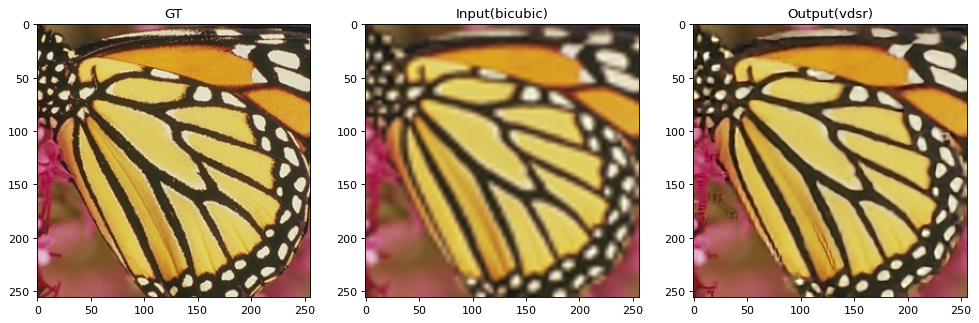

In [16]:
# Result visualization
fig = plt.figure(figsize=(15, 5), dpi= 80)
ax = plt.subplot(1, 3, 1)
ax.imshow(im_gt)
ax.set_title("GT")

ax = plt.subplot(1, 3, 2)
ax.imshow(im_b)
ax.set_title("Input(bicubic)")

ax = plt.subplot(1, 3, 3)
ax.imshow(im_h)
ax.set_title("Output(vdsr)")
plt.show()
imagename = os.path.basename(gt_path).split('_')[0]
if not os.path.exists("images/"):
    os.makedirs("images/")
fig.savefig("images/" + imagename + '.jpg')